# KTR Pyro Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktr import KTRFull, KTRAggregated, KTRMAP
from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx import KTRXAggregated

from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.metrics import smape

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## Pyro Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [12]:
ktr_pyro = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=365.25 / 7,
    seasonality_fs_order=5,
    
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    level_knot_scale=10, 
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
 
    span_level=0.1,
    span_coefficients=0.2,
    # rho_level=0.05, # doesn matter anymore
    rho_coefficients=0.15,
    
#     insert_prior_regressor_col=['trend.filling'] * 50,
#     insert_prior_tp_idx=np.arange(100, 150),
#     insert_prior_mean=np.array([0.2] * 50),
#     insert_prior_sd=np.array([0.1] * 50),
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    n_bootstrap_draws=200,
    estimator_type=PyroEstimatorVI,
)

In [13]:
%%time
ktr_pyro.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 7163, scale = 0.096817
step  100 loss = -236.6, scale = 0.52614
step  200 loss = -244.34, scale = 0.54499
step  300 loss = -243.95, scale = 0.55872
step  400 loss = -243.8, scale = 0.55716
step  500 loss = -239.96, scale = 0.55561
step  600 loss = -247.88, scale = 0.55641
step  700 loss = -243.22, scale = 0.55311
step  800 loss = -245.24, scale = 0.5449
step  900 loss = -243.52, scale = 0.55562
CPU times: user 3min 57s, sys: 7.94 s, total: 4min 5s
Wall time: 23 s


In [14]:
predicted_df = ktr_pyro.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.21906,12.35845,12.50949
1,2017-07-09,12.19674,12.34888,12.48742
2,2017-07-16,12.20992,12.33343,12.48573
3,2017-07-23,12.16992,12.31580,12.48603
4,2017-07-30,12.16098,12.30818,12.43796


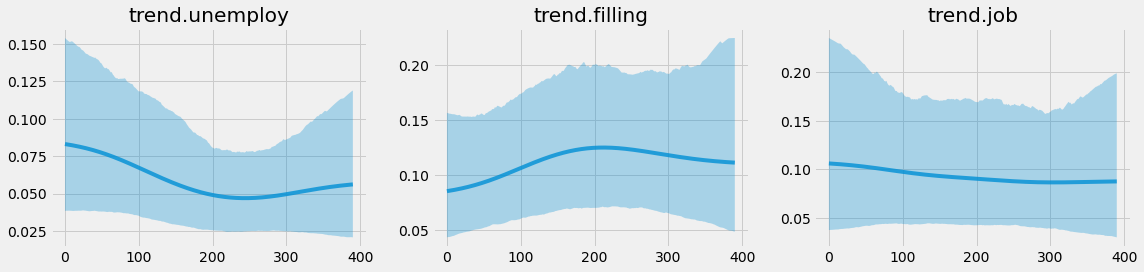

In [15]:
_ = ktr_pyro.plot_regression_coefs(ncol=3, figsize=(16, 4), include_ci=True)

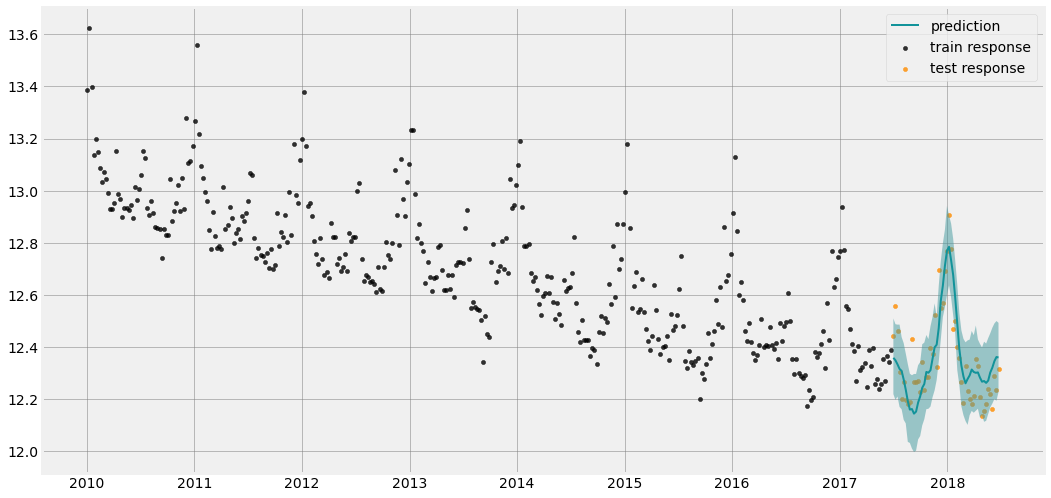

In [16]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [17]:
coef_df = ktr_pyro.get_regression_coefs(aggregate_method='mean')
coef_df.head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.08320,0.08546,0.10621
1,2010-01-10,0.08312,0.08556,0.10616
2,2010-01-17,0.08304,0.08567,0.10612
3,2010-01-24,0.08296,0.08578,0.10607
4,2010-01-31,0.08288,0.08589,0.10602


In [18]:
ktr_pyro = KTRAggregated(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale=10,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
    
    span_level=0.1,
    span_coefficients=0.2,
    #rho_level=0.05, # doesnt matter anymore
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=False,
    message=100,
    aggregate_method='median',
    estimator_type=PyroEstimatorVI,
)

In [19]:
ktr_pyro.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


In [21]:
predicted_df = ktr_pyro.predict(df=test_df)
predicted_df.head()

,week,prediction
0,2017-07-02,12.38170
1,2017-07-09,12.39453
2,2017-07-16,12.37701
3,2017-07-23,12.35411
4,2017-07-30,12.32796


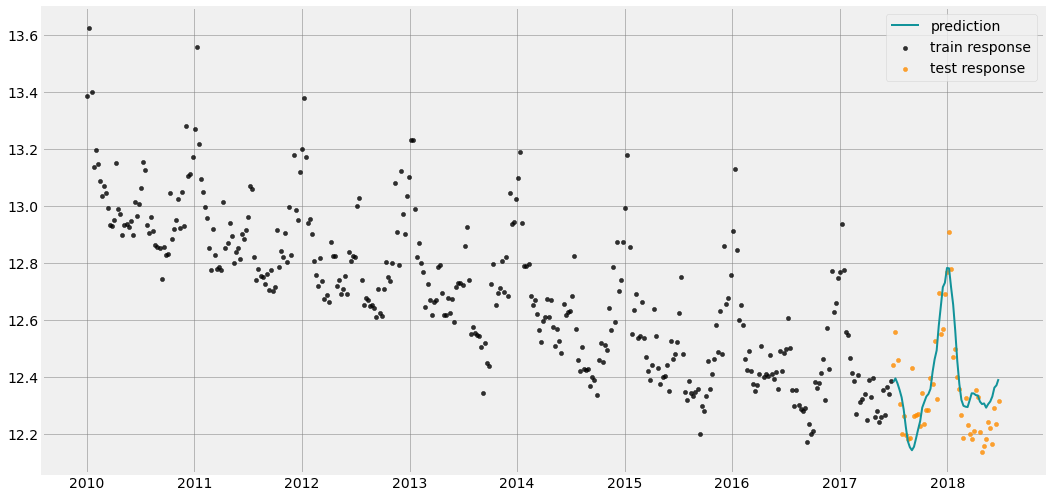

In [22]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

## Stan Fit and Predict

In [7]:
ktr_stan = KTRFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] * 3,
    
    level_knot_scale = .5, # smaller due to drift term; no big difference?
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
 
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05, # doesnt matter
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
#     num_warmup = num_warmup,
#     num_sample = num_sample,
    n_bootstrap_draws=-1,
    estimator_type=StanEstimatorMCMC,
)

In [8]:
%%time
ktr_stan.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 211 ms, sys: 128 ms, total: 339 ms
Wall time: 37 s


In [9]:
predicted_df = ktr_stan.predict(df=test_df, random_state=123)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.18078,12.35741,12.53098
1,2017-07-09,12.20770,12.37595,12.53377
2,2017-07-16,12.17263,12.35928,12.50025
3,2017-07-23,12.17818,12.34334,12.53713
4,2017-07-30,12.12223,12.33052,12.46849


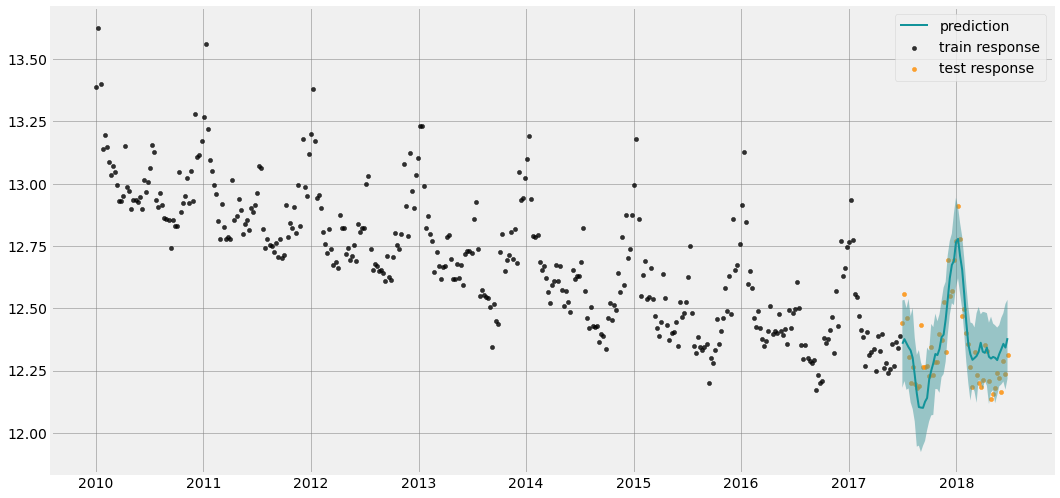

In [10]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

In [11]:
ktr_stan = KTRMAP(
    response_col='claims',
    date_col='week',
    seasonality=365.25/7,
    seasonality_fs_order=5,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['+'] *3,
    
    level_knot_scale = .5,
    regressor_knot_pooling_loc=[0] * 3,
    regressor_knot_pooling_scale=[1] * 3,
    regressor_knot_scale=[.1] * 3,
    
    span_level=0.1,
    span_coefficients=0.2,
    rho_level=0.05, # doesnt matter anymore
    rho_coefficients=0.15,
    
    insert_prior_regressor_col=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    estimator_type=StanEstimatorMAP,
)

In [12]:
%%time
ktr_stan.fit(df=train_df)

CPU times: user 328 ms, sys: 10.9 ms, total: 339 ms
Wall time: 338 ms


In [13]:
predicted_df = ktr_stan.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_52.17857142857143,regression
0,2017-07-02,12.38483,12.36947,0.01529,0.00007
1,2017-07-09,12.38659,12.36947,0.01709,0.00003
2,2017-07-16,12.37816,12.36947,0.00864,0.00005
3,2017-07-23,12.35805,12.36947,-0.01145,0.00002
4,2017-07-30,12.32619,12.36947,-0.04332,0.00004


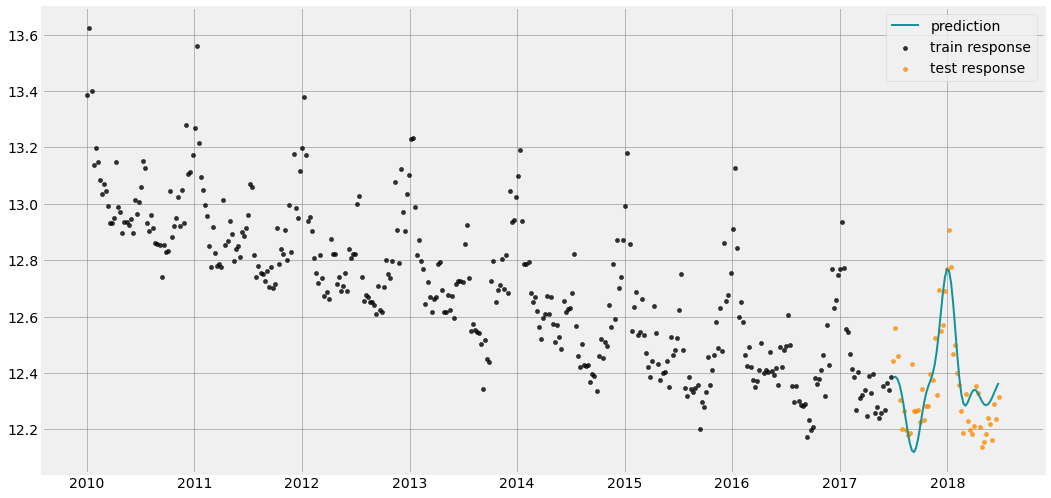

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

## KTRLiteMAP and KTRXAggregated

In [23]:
ktr_stan = KTRLiteMAP(
    response_col='claims',
    date_col='week',
    # seasonality
    seasonality=365.25/7,
    seasonality_fs_order=5,
    level_knot_scale=.5,
    span_level=.1,
    span_coefficients=.3,
    rho_coefficients=.15,
    estimator_type=StanEstimatorMAP,
)
ktr_stan.fit(train_df)

level_knot_dates = ktr_stan._level_knot_dates
level_knots = ktr_stan._aggregate_posteriors['map']['lev_knot'][0]
seasonal_knots_input = {
    '_seas_coef_knot_dates': ktr_stan._coef_knot_dates,
    '_sea_coef_knot': ktr_stan._aggregate_posteriors['map']['coef_knot'],
    '_sea_rho': ktr_stan.rho_coefficients,
    '_seasonality': ktr_stan._seasonality,
    '_seasonality_fs_order': ktr_stan._seasonality_fs_order,
} 

In [27]:
ktr_pyro = KTRXAggregated(
    response_col='claims',
    date_col='week',
    level_knot_dates=level_knot_dates,
    level_knots=level_knots,
    seasonal_knots_input=seasonal_knots_input,
    level_knot_scale=.1, #.01
    span_coefficients=0.3,
    rho_coefficients=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    #learning_rate_total_decay=0.05,
    verbose=False,
    message=100,
    aggregate_method="median",
    estimator_type=PyroEstimatorVI,
)

ktr_pyro.fit(train_df)

INFO:root:Guessed max_plate_nesting = 2


In [28]:
predicted_df = ktr_pyro.predict(df=test_df)
predicted_df.head()

,week,prediction
0,2017-07-02,12.38748
1,2017-07-09,12.38258
2,2017-07-16,12.36482
3,2017-07-23,12.33594
4,2017-07-30,12.29909


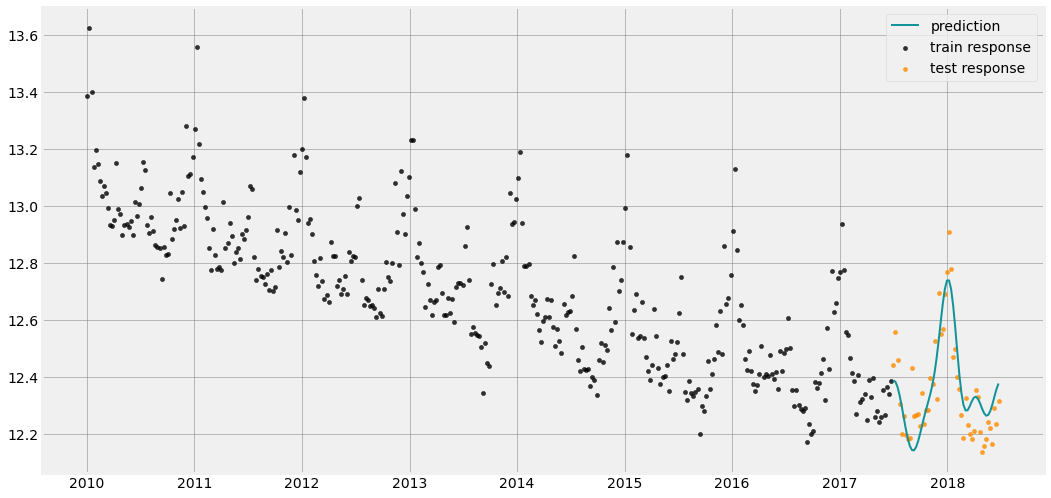

In [29]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

## hyper-parameter tuning [TO Check]

In [37]:
from orbit.diagnostics.backtest import grid_search_orbit
from orbit.diagnostics.metrics import smape, mape, wmape

In [38]:
# param_grid = {'num_steps': [100, 1000]}

param_grid = {'span_level': [0.1, 0.2], 'span_coefficients': [0.2, 0.3],
              'rho_level': [0.05, 0.1], 'rho_coefficients': [0.15, 0.2]}

In [40]:
best_params, tuned_df = grid_search_orbit(param_grid, 
                                        model=ktr_map, 
                                        df=df,
                                        min_train_len=100, incremental_len=100, forecast_len=20, 
                                        metrics=None, criteria=None, verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


  6%|▋         | 1/16 [00:15<03:48, 15.21s/it]

tuning metric:0.065393
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 12%|█▎        | 2/16 [00:30<03:33, 15.26s/it]

tuning metric:0.012355
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 19%|█▉        | 3/16 [00:45<03:18, 15.30s/it]

tuning metric:0.090586
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 25%|██▌       | 4/16 [01:00<03:00, 15.05s/it]

tuning metric:0.081442
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 31%|███▏      | 5/16 [01:14<02:43, 14.89s/it]

tuning metric:0.068079
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 38%|███▊      | 6/16 [01:29<02:28, 14.84s/it]

tuning metric:0.15421
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 44%|████▍     | 7/16 [01:44<02:13, 14.85s/it]

tuning metric:0.012057
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


 50%|█████     | 8/16 [01:59<01:58, 14.75s/it]

tuning metric:0.16231
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


 56%|█████▋    | 9/16 [02:13<01:42, 14.70s/it]

tuning metric:0.068675
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 62%|██████▎   | 10/16 [02:28<01:28, 14.68s/it]

tuning metric:0.15767
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 69%|██████▉   | 11/16 [02:42<01:13, 14.62s/it]

tuning metric:0.072529
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 75%|███████▌  | 12/16 [02:57<00:58, 14.59s/it]

tuning metric:0.085704
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 81%|████████▏ | 13/16 [03:11<00:43, 14.56s/it]

tuning metric:0.086096
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 88%|████████▊ | 14/16 [03:26<00:29, 14.62s/it]

tuning metric:0.13729
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 94%|█████████▍| 15/16 [03:41<00:14, 14.62s/it]

tuning metric:0.08159
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


100%|██████████| 16/16 [03:55<00:00, 14.74s/it]

tuning metric:0.1716


In [43]:
tuned_df.head()

,rho_coefficients,rho_level,span_coefficients,span_level,metrics
0,0.15000,0.05000,0.20000,0.10000,0.06539
1,0.15000,0.05000,0.20000,0.20000,0.01235
2,0.15000,0.05000,0.30000,0.10000,0.09059
3,0.15000,0.05000,0.30000,0.20000,0.08144
4,0.15000,0.10000,0.20000,0.10000,0.06808


In [42]:
best_params

[{'rho_coefficients': 0.15,
  'rho_level': 0.1,
  'span_coefficients': 0.3,
  'span_level': 0.1}]